In [1]:
import os
import subprocess
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import re
from pymatgen.io.lammps.outputs import parse_lammps_log
import numpy as np
from itertools import product

## Checks to see if we have all of the structures we expect to have

In [2]:
def find_missing_xyz_files(theta_range=None, phi_range=None):
    filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")
    directories = ["XYZ_Files", "Hydrogenated_XYZ_Files", "Hydrogenated_Improper_XYZ_Files"]
    
    # If ranges are not provided, use a default range (0 to 360)
    if theta_range is None:
        theta_range = range(0, 360, 10)
    if phi_range is None:
        phi_range = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60]

    missing_files = []

    for dir in directories:
        if not os.path.exists(dir):
            print(f"Directory {dir} does not exist.")
            continue

        # Create a set of all expected combinations
        expected_combinations = set(product(theta_range, phi_range))

        for file in os.listdir(dir):
            match = filename_pattern.search(file)
            if match:
                phi, theta = int(match.group(1)), int(match.group(2))
                if (theta, phi) in expected_combinations:
                    expected_combinations.remove((theta, phi))

        # Add remaining combinations as missing for this directory
        for theta, phi in expected_combinations:
            missing_files.append(f"{dir}: Missing Phi {phi}, Theta {theta}")

    print(f"Found {len(missing_files)} missing files.")
    return missing_files

### Missing files here can possibly be recovered by converting the QChem output files in the corresponding QChem output directories to xyz files.

In [3]:
# Example usage
missing = find_missing_xyz_files()
for file in missing:
    print(file)

Directory XYZ_Files does not exist.
Directory Hydrogenated_XYZ_Files does not exist.
Directory Hydrogenated_Improper_XYZ_Files does not exist.
Found 0 missing files.


In [4]:
title = {'fontsize':20}
axes = {'fontsize':16}

### Define a set of functions for data manipulation and acquisition

### I think ideally these should be moved to a python file and imported rather than being redefined in each analysis notebook

In [5]:
# Define a function for parsing QChem outfiles with structured naming scheme
def extract_qchem_energies(path, filename_pattern, energy_pattern):
    """
    Extracts energy values from QChem output files located in a specified directory,
    matching a given filename pattern and energy line pattern.

    Parameters:
    - path (str): Path to the directory containing the output files.
    - filename_pattern (re.Pattern): Compiled regular expression pattern to match and extract
      phi and theta values from the filenames.
    - energy_pattern (re.Pattern): Compiled regular expression pattern to match and extract
      energy values from the file contents.

    Returns:
    - dict: A nested dictionary where the first level keys are phi values, the second level keys
      are theta values, and the values are the corresponding energy values extracted from the files.
    
    The function also prints a warning message for files where the energy value or phi and theta
    values cannot be extracted according to the given patterns.
    """
    # Initialize nested dictionary
    data = {}
    # Loop through each file in the directory
    for filename in os.listdir(path):
        if filename.endswith(".out"): # and filename.startswith("Me"):
            # Extract phi and theta from filename
            match = filename_pattern.search(filename)
            if match:
                phi = int(match.group(1))
                theta = int(match.group(2)) if match.group(2) else 0


                # Read file and search for energy
                with open(os.path.join(path, filename), 'r') as f:
                    energy_found = False
                    for line in f:
                        energy_match = energy_pattern.search(line)
                        if energy_match:
                            energy = float(energy_match.group(1)) 
    
                            # Store in nested dictionary
                            if phi not in data:
                                data[phi] = {}
                            data[phi][theta] = energy
    
                            energy_found = True
                            break
    
                    # Throw a warning if energy is not found
                    if not energy_found:
                        print(f"Warning: Energy not found in file {filename}")
            else:
                print(f"Warning: Could not extract Phi and Theta values from filename {filename}")
    return data

def check_QM_completion(e_dict):
    """
    Checks and prints the completeness of quantum mechanics (QM) calculations by analyzing
    the distribution of theta values for each phi value in the given energy dictionary.

    Parameters:
    - e_dict (dict): A nested dictionary where the first level keys are phi values, the second
      level keys are theta values, and the values are energy values.

    Returns:
    - None: This function only prints the sorted phi keys and the count of theta values for each
      phi, helping to visually inspect the completeness of QM calculations.
    """
    test = {}
    for phi in e_dict:
        test[phi]=[]
        for theta in e_dict[phi]:
            test[phi].append(theta)
    
    print(sorted(test.keys()))
    for i in sorted(test.keys()):
        print(i, len(test[i]))

# TODO: update this function to reflect the finalized calculation method
def calc_deloc_energies(total_dict, hyd_dict, meth_dict, conj_dict):
    """
    Calculates delocalization energies from the given energy dictionaries and creates a DataFrame
    with the results, including normalized methylene energies and new calculated values.

    Parameters:
    - total_dict (dict): Energy dictionary for total system.
    - hyd_dict (dict): Energy dictionary for the hydrogenated system.
    - meth_dict (dict): Energy dictionary for the methylated system.

    Returns:
    - pd.DataFrame: A DataFrame containing phi, theta, delocalization energy (E_deloc), nonbonded energy (E_nonbond),
      hydrogenated system energy (E_hyd), total system energy (E_tot), methylated system energy (E_meth),
      normalized methylated energy (norm_E_meth), new nonbonded energy (new_E_nb), and new delocalization energy (new_E_deloc)
      sorted by Theta and Phi.
    """
    data = []
    for phi in conj_dict:

        # We want E_conjugation for each value of phi
        # E_conjugation is a scalar correction factor to the delocalization energy
        # for each value of phi
        # E_conjugation might be a separate dictionary, could just call the desired phi value when needed
        
        for theta in total_dict[phi]:
            E_nonbond = hyd_dict[phi][theta] - (meth_dict[phi][theta] - conj_dict[phi][0])
            E_deloc = (total_dict[phi][theta]) - E_nonbond 

            data.append([phi, theta, E_deloc, E_nonbond, hyd_dict[phi][theta], total_dict[phi][theta], meth_dict[phi][theta]])

    df = pd.DataFrame(data, columns=['Phi', 'Theta', 'E_deloc', 'E_nonbond', 'E_hyd', 'E_tot', 'E_meth'])
    sorted_df = df.sort_values(['Theta', 'Phi'])
    
    new_e_meth = []
    for phi in sorted_df['Phi'].unique():
        subset = sorted_df[sorted_df['Phi'] == phi]
        min = np.min(subset['E_meth'])
        norm = np.array(subset['E_meth'] - min)
        new_e_meth.append(norm)
    
    sorted_df['norm_E_meth'] = [i for sub in new_e_meth for i in sub]
    sorted_df['new_E_nb'] = sorted_df['E_hyd'] - sorted_df['norm_E_meth']
    sorted_df['new_E_deloc'] = sorted_df['E_tot'] - sorted_df['new_E_nb']
    
    return sorted_df

# Function to read XYZ coordinates
def read_xyz(filename):
    """
    Reads atomic coordinates from an XYZ file.

    Parameters:
    - filename (str): Path to the XYZ file.

    Returns:
    - list of tuples: A list where each tuple represents the x, y, and z coordinates of an atom.
    
    The function skips the first two lines of the XYZ file, which typically contain the number of atoms
    and a comment, respectively.
    """
    coords = []
    with open(filename, 'r') as f:
        for _ in range(2):  # Skip the first two lines
            next(f)
        for line in f:
            _, x, y, z = line.split()
            coords.append((float(x), float(y), float(z)))
    return coords


# Function to update LAMMPS data file with new coordinates
def update_lammps_data(lammps_file, new_coords, output_file):
    """
    Updates a LAMMPS data file with new atomic coordinates.

    Parameters:
    - lammps_file (str): Path to the original LAMMPS data file.
    - new_coords (list of tuples): New atomic coordinates to update in the data file, where each tuple contains the x, y, and z coordinates.
    - output_file (str): Path where the updated LAMMPS data file will be saved.

    Returns:
    - None: This function writes directly to a new file specified by `output_file`, replacing the atomic coordinates
      section with the new coordinates while preserving the rest of the data file structure.
    """
    with open(lammps_file, 'r') as f_in, open(output_file, 'w') as f_out:
        atom_section = False
        i = 0  # Index for new_coords
        for line in f_in:
            if "Atoms" in line:                          
                atom_section = True
                f_out.write(line)
                next(f_in)  # Skip the empty line after "Atoms"
                f_out.write("\n")
                continue
            elif "Bonds" in line or "Velocities" in line:
                atom_section = False

            if atom_section:
                parts = line.split()
                if len(parts) == 7:  # id molecule_type atom_type charge x y z
                    new_line = f"{parts[0]}\t{parts[1]}\t{parts[2]}\t{parts[3]}\t{new_coords[i][0]:.6f}\t{new_coords[i][1]:.6f}\t{new_coords[i][2]:.6f}\n"
                    f_out.write(new_line)
                    i += 1
                else:
                    f_out.write(line)
            else:
                f_out.write(line)

## Verify that we have all the QChem output files we're expecting

#### Need to add a check/condition to look for the `E_conjugation` data that we will be incorporating

In [6]:
# Specify directory to search for files
directory_path = "./old-outputs/Standard_Dimer_Scan_Outputs/"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_total = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_total = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_total)
check_QM_completion(rimp2_total)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36
[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


In [7]:
# Specify directory to search for files
directory_path = "./old-outputs/Hydrogenated_Dimer_Scan_Outputs/"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_hyd = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_hyd = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_hyd)
check_QM_completion(rimp2_hyd)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36
[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


In [8]:
# Specify directory to search for files
directory_path = "./methylated-rotation-run"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_meth = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_meth = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_meth)
check_QM_completion(rimp2_meth)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36
[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


In [9]:
directory_path = "./E_conjugation"

filename_pattern = re.compile(r"_Phi_(\d+)(?:_Theta_(\d+)_)?")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")
energy_conj = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_conj = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_conj)
check_QM_completion(rimp2_conj)


[0, 5, 10, 15, 20, 25, 30]
0 1
5 1
10 1
15 1
20 1
25 1
30 1
[0, 5, 10, 15, 20, 25, 30]
0 1
5 1
10 1
15 1
20 1
25 1
30 1


# Search for method to calculate delocalization energies across improper angles

### Key variables:  
`E_delocalization`
`Dimer_Energies_Corrected`
`E_conjugation`
`Ring_By_Ring_Nonbonded_Energies`
`Ring_By_Ring_Methyl_Impropers`  

### Torsional_Parameterization_v6_P3HT_Corrected_TS.ipynb: 

#### Original formulation:  
`#E_delocalization = Dimer_Energies - Ring_By_Ring_Nonbonded_Energies`  
Corrected formulation:  
`E_delocalization = Dimer_Energies_Corrected - E_conjugation - Ring_By_Ring_Nonbonded_Energies`

#### Components:  

Dimer_Energies_Corrected  
`Dimer_Energies,Dimer_Energies_Dict,Dimer_Energies_Corrected = Return_SPE_Dimers(Ring_List, Rotated_Shape, Max_Dih, Max_OOP, Polymer_Name, Ring_By_Ring_End_File_Matrices,Ring_By_Ring_Nontorsional_Energy, Ring_By_Ring_Hydrogenated_Energies)`  

E_conjugation:  
`E_conjugation = np.asarray(Ring_By_Ring_Methyl_Impropers)`  

Ring_By_Ring_Nonbonded_Energies:  
`Ring_By_Ring_Nonbonded_Energies = np.asarray(Combined_Ring_By_Ring_Hydrogenated_Energies) - np.asarray(Combined_Ring_By_Ring_Hydrogenated_Improper_Energies)`  


##### Subcomponents:  

Ring_By_Ring_Methyl_Impropers:  
`Ring_By_Ring_Methyl_Impropers = []`
```    
for ring1,ring2,Improper_File_Matrix in zip(Ring1_List,Ring2_List,Ring_By_Ring_Improper_File_Matrices):
    Improper_Energies = []
    ...

    for End_File_List in Improper_File_Matrix:
        Improper_Energies.append(Cluster_IO.Return_Info_Batch(...)
    Improper_Energies = np.asarray(Improper_Energies)
    Improper_Energies = Improper_Energies - Improper_Energies[0][0]
    Ring_By_Ring_Methyl_Impropers.append(Improper_Energies)
```

Dimer_Energies_Corrected = Full_Corrected_Energies.append(Corrected_Energy_Matrix)

Corrected_Energy_Matrix = Corrected_Energy_Matrix - np.amin(Corrected_Energy_Matrix[0])

...  I think the "Nontorsional Energies", whatever the fuck that means, come from LAMMPS

Corrected_Energy_Matrix = Raw_Energies - Nontorsional_Energy_Matrix

        Raw_Energies = np.asarray(Raw_Energies)
        Raw_Energies = Raw_Energies - np.amin(Raw_Energies)

    for ring1,ring2,End_File_Matrix,Nontorsional_Energy_Matrix,Hydrogenated_Energy in zip(Ring1_List,Ring2_List,Ring_By_Ring_End_File_Matrices,Ring_By_Ring_Nontorsional_Energy,Ring_By_Ring_Hydrogenated_Energy):


### Calculate and plot the RIMP2-corrected delocalization energy for P3HT

In [10]:
energy_df = calc_deloc_energies(energy_total, energy_hyd, energy_meth, energy_conj) # Total energy
rimp2_df = calc_deloc_energies(rimp2_total, rimp2_hyd, rimp2_meth,rimp2_conj)     # Total energy including RIMP2 corrections
sorted_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
sorted_deloc.head()

,Phi,Theta,E_deloc,E_nonbond,E_hyd,E_tot,E_meth,norm_E_meth,new_E_nb,new_E_deloc
105,0,0,1.120550,-1576.433725,-1576.391903,-1575.313175,-591.373922,0.002012,-1576.393915,1.080740
41,5,0,1.120632,-1576.433423,-1576.391911,-1575.312791,-591.374120,0.002099,-1576.394010,1.081219
216,10,0,1.120716,-1576.432243,-1576.390966,-1575.311527,-591.373506,0.002230,-1576.393195,1.081669
204,15,0,1.120817,-1576.430255,-1576.389126,-1575.309438,-591.372071,0.002413,-1576.391539,1.082100
5,20,0,1.120954,-1576.427359,-1576.386275,-1575.306404,-591.369797,0.002625,-1576.388900,1.082496


In [11]:
from matplotlib.cm import viridis 
from matplotlib.colors import Normalize

phis = sorted_deloc['Phi'].unique()
phis.sort()

cmap = viridis
norm = Normalize(vmin=np.min(phis), vmax=np.max(phis))

In [12]:
title = {'fontsize':20}
axes = {'fontsize':16}

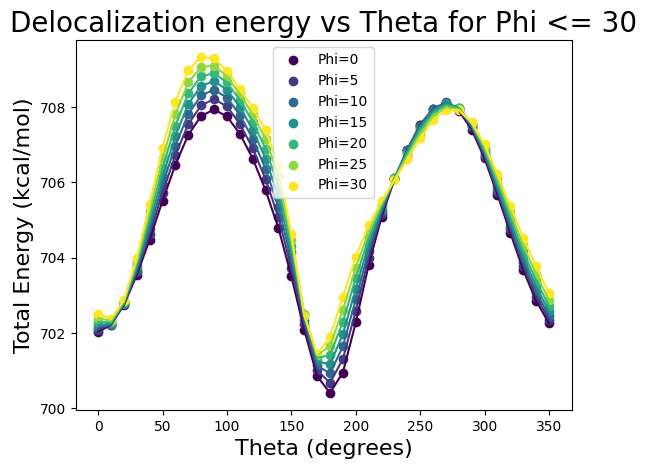

In [13]:
min_e = np.min(sorted_deloc['E_deloc'])
for phi in phis:
    if phi <= 30:
        subset = sorted_deloc[sorted_deloc['Phi'] == phi]
        # e_conjugation = subset[subset['Theta'] == 0]['E_meth'].iloc[0]
        # min_energy = np.min(sorted_deloc['E_deloc'])
        # print(e_conjugation, min_energy)
        normed_energy = 627.509 * (subset['E_deloc'])  # Normalize energy
        normed_energy = normed_energy - min_e  # Normalize energy
        # energy = 627.509 * subset['E_deloc']

        # Map phi value to a color
        color = cmap(norm(phi))

        # Plot the normalized energy vs theta
        plt.plot(subset['Theta'], normed_energy, color=color)  # Replace 'E_total' with the actual column name for total energy
        plt.scatter(subset['Theta'], normed_energy, color=color, label=f"Phi={phi}")  # Replace 'E_total' with the actual column name for total energyy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
# plt.ylim(0,5)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.legend()
plt.show()

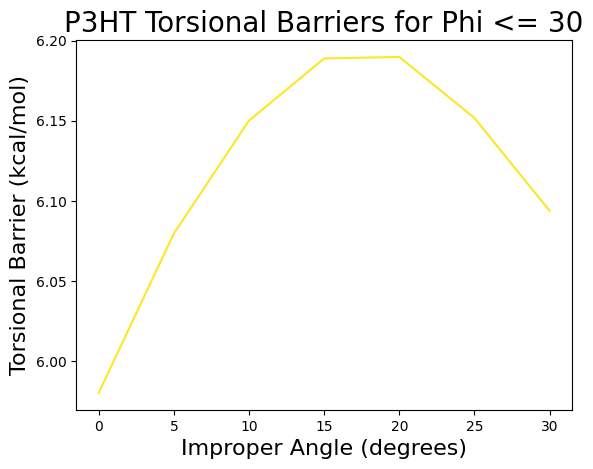

In [14]:
def show_energy_barriers(energy_df):
    barriers =[]
    phis_used=[]
    for phi in phis:
        if phi <= 30:
            subset = energy_df[energy_df['Phi'] == phi]
            # e_conjugation = subset[subset['Theta'] == 0]['E_meth'].iloc[0]
            # normed_energy = 627.509 * (subset['E_deloc'] - e_conjugation)  # Normalize energy
            # normed_energy = normed_energy - 689  # Normalize energy
            # max = np.max(normed_energy)
            max1 = subset['E_deloc'][subset['Theta'] == 90].values[0]
            max2 = subset['E_deloc'][subset['Theta'] == 270].values[0]
            # min = np.min(normed_energy)
            min = subset['E_deloc'][subset['Theta'] == 0].values[0]

            barrier = ((max1 - min) + (max2 - min))/2

            phis_used.append(phi)
            barriers.append(barrier*627.509)
    plt.plot(phis_used, barriers, color=color) 
    plt.xlabel('Improper Angle (degrees)', fontdict=axes)
    plt.ylabel('Torsional Barrier (kcal/mol)', fontdict=axes)
    plt.title(f'P3HT Torsional Barriers for Phi <= 30', fontdict=title)
    plt.show()

show_energy_barriers(rimp2_df)

In [15]:
import pickle

with open('data.pkl', 'wb') as file:
    pickle.dump({'sorted_deloc': rimp2_df, 'phis': phis}, file)

{20: {0: -591.4108804476}, 5: {0: -591.4156321669}, 0: {0: -591.415743823}, 25: {0: -591.4078147635}, 30: {0: -591.4039870329}, 15: {0: -591.4132000238}, 10: {0: -591.4147827471}}


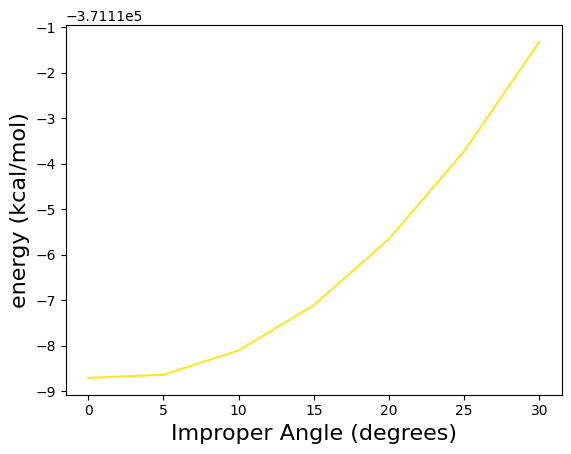

In [16]:
print(rimp2_conj)
barriers =[]
phis_used=[]
for phi in phis:
    if phi <= 30:
        subset = rimp2_conj[phi]
        num = subset[0]
        phis_used.append(phi)
        barriers.append((num)*627.509)
plt.plot(phis_used, barriers, color=color) 
plt.xlabel('Improper Angle (degrees)', fontdict=axes)
plt.ylabel('energy (kcal/mol)', fontdict=axes)
plt.show()